In [1]:
from torch import nn
import torch
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import os
import anndata
import math
import hnswlib
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
from modules import network,mlp
from utils import yaml_config_hook,save_model

parser = argparse.ArgumentParser()
config = yaml_config_hook("config/config.yaml")
for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))
args = parser.parse_args([])
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

# torch.manual_seed(args.seed)
# torch.cuda.manual_seed_all(args.seed)
# torch.cuda.manual_seed(args.seed)
# np.random.seed(args.seed)
class_num = args.classnum

In [3]:
import scipy.sparse
from outlier import transformation,outlier_utils
sparse_X = scipy.sparse.load_npz('data/filtered_Counts.npz')
X=sparse_X.toarray()
annoData = pd.read_table('data/annoData.txt')
y_ndarray = annoData["cellIden"].to_numpy()

print(np.where(X ==0)[0].shape[0]/(X.shape[0]*X.shape[1]))
cluster_number = np.unique(y_ndarray).shape[0]
nb_genes = 500


x_ndarray = transformation.preprocess(X, nb_genes = args.num_genes)

0.9062240736324567
(8569, 20125) (8569, 20125) keeping 500 genes


In [4]:
from torch.utils.data import DataLoader,random_split,TensorDataset
scDataset = TensorDataset(torch.tensor(x_ndarray, dtype=torch.float32),
                              torch.tensor(y_ndarray, dtype=torch.float32))

scDataLoader = DataLoader(scDataset, shuffle=True, batch_size=args.batch_size,drop_last=True)

for features, labels in scDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

scGenDataLoader = DataLoader(scDataset, shuffle=False, batch_size=args.batch_size,drop_last=True)

for features, labels in scDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

500
1024
1024
500
1024
1024


In [5]:
num_elements=len(scDataset)
dim=args.num_genes
print(num_elements,dim)
p=hnswlib.Index(space='cosine',dim=dim)
p.init_index(max_elements=num_elements, ef_construction=100, M=16)
p.set_ef(100)
p.set_num_threads(4)
p.add_items(x_ndarray)

8569 500


In [6]:
# initialize model
mlp = mlp.MLP_500(num_genes=args.num_genes)
model = network.Network(mlp, args.feature_dim, args.classnum)
model = model.to('cuda')
# optimizer / loss
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

In [7]:
class InstanceLoss(nn.Module):

    def __init__(self,batch_size,temperature,device):
        super(InstanceLoss,self).__init__()
        self.batch_size=batch_size
        self.temperature=temperature
        self.device=device

        self.mask=self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")


    def mask_correlated_samples(self,batch_size):
        N=2*batch_size
        mask=torch.ones(N,N)
        mask=mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i,batch_size+1]=0
            mask[batch_size+i,i]=0
        mask=mask.bool()
        return mask

    def forward(self,z_i,z_j):
        N=2*self.batch_size
        z=torch.cat((z_i,z_j),dim=0)

        sim=torch.matmul(z,z.T)/self.temperature
        sim_i_j=torch.diag(sim,self.batch_size)
        sim_j_i=torch.diag(sim,-self.batch_size)

        positive_samples= torch.cat((sim_i_j,sim_j_i),dim=0).reshape(N,1)
        negative_samples=sim[self.mask].reshape(N,-1)

        labels = torch.zeros(N).to(positive_samples.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss

In [8]:
class ClusterLoss(nn.Module):
    def __init__(self, class_num, temperature, device):
        super(ClusterLoss, self).__init__()
        self.class_num = class_num
        self.temperature = temperature
        self.device = device

        self.mask = self.mask_correlated_clusters(class_num)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_clusters(self, class_num):
        N = 2 * class_num
        mask = torch.ones((N, N))
        mask = mask.fill_diagonal_(0)
        for i in range(class_num):
            mask[i, class_num + i] = 0
            mask[class_num + i, i] = 0
        mask = mask.bool()
        return mask

    def forward(self, c_i, c_j):
        p_i = c_i.sum(0).view(-1)
        p_i /= p_i.sum()
        ne_i = math.log(p_i.size(0)) + (p_i * torch.log(p_i)).sum()
        p_j = c_j.sum(0).view(-1)
        p_j /= p_j.sum()
        ne_j = math.log(p_j.size(0)) + (p_j * torch.log(p_j)).sum()
        ne_loss = ne_i + ne_j

        c_i = c_i.t()
        c_j = c_j.t()
        N = 2 * self.class_num
        c = torch.cat((c_i, c_j), dim=0)

        sim = self.similarity_f(c.unsqueeze(1), c.unsqueeze(0)) / self.temperature
        sim_i_j = torch.diag(sim, self.class_num)
        sim_j_i = torch.diag(sim, -self.class_num)

        positive_clusters = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_clusters = sim[self.mask].reshape(N, -1)

        labels = torch.zeros(N).to(positive_clusters.device).long()
        logits = torch.cat((positive_clusters, negative_clusters), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss + ne_loss


In [9]:
class MemoryBank():

    # 初始化，传入参数
    def __init__(self,batch_size,full_data,topK=10):
        self.topK=topK
        self.batch_size=batch_size
        self.bank=None
        self.full_data=full_data

    # 根据在updateBank中更新的hnsw对象以及输入的数据data（这里可以是embedding）提取TopK个近邻的数据
    # 返回的结果是一个形状为[TopK,batch_size,num_genes]的数组，从第一个维度来看，
    # 每个[batch_size,num_genes]的子数组都是根据输入的数据data寻找的一个近邻，一共TopK个
    def generateContrast(self,data):
        if self.bank is not None:
            contrasts=np.empty((self.topK,args.batch_size,args.num_genes))
            labels,distances=self.bank.knn_query(data,k=self.topK)
            
            # print(labels)

            for step,label in enumerate(labels):
                contrasts[:,step]=self.full_data[label.tolist()]
            return contrasts
        else:
            print('Memory Bank has not been initialized......')
            raise NotImplementedError()

    # 根据输入的embedding更新hnsw对象
    def updateBank(self,embedding):
        num_elements=len(embedding)
        dim=embedding.shape[1]
        self.bank=hnswlib.Index(space='cosine',dim=dim)
        self.bank.init_index(max_elements=num_elements, ef_construction=100, M=16)
        self.bank.set_ef(100)
        self.bank.set_num_threads(4)
        self.bank.add_items(embedding)

In [10]:

# def train(instance_loss,cluster_loss):
#     loss_epoch = 0
#     for step, (data,label) in enumerate(scDataset):
#         optimizer.zero_grad()
        
#         x_i=data.clone().numpy()
        
#         labels, distances = p.knn_query(x_i, k=31)
#         labels=labels.squeeze()
#         contrastive=x_ndarray[labels.tolist()]
#         input=np.row_stack((contrastive,x_i))
#         input_1=input.copy()
#         np.random.shuffle(input_1)
#         x_a=torch.from_numpy(input).to('cuda')
#         x_b=torch.from_numpy(input_1).to('cuda')
        
#         z_i,z_j,c_i,c_j=model(x_a,x_b)
#         loss_instance=instance_loss(z_i,z_j)
#         loss_cluster=cluster_loss(c_i,c_j)
#         loss = loss_instance + loss_cluster
#         loss.backward()
#         optimizer.step()
#         if step % 1000 == 0:
#             print(f"Step [{step}/{len(scDataLoader)}]\t loss_instance: {loss_instance.item()}\t loss_cluster: {loss_cluster.item()}")
#         loss_epoch += loss.item()
#     return loss_epoch


In [11]:
def train(instance_loss,cluster_loss,memory_bank,model,epoch):
    loss_epoch=0
    for step,(data,label) in enumerate(scDataLoader):
        optimizer.zero_grad()
        
        # if epoch<20:
        embedding_data=data.numpy().copy()
        data=data.to('cuda')
        # else:
        #     data=data.to('cuda')
        #     embedding_data=model.forward_embedding(data).cpu().detach().numpy()    
        contrast_samples=memory_bank.generateContrast(embedding_data)
        iter_times=contrast_samples.shape[0]
        for sample in contrast_samples:
            # print(f'sample shape:\n{sample.shape}')
            # print(f'data shape:\n{data.shape}')
            x_i=data.clone()
            x_j=torch.tensor(sample,dtype=torch.float32).to('cuda')

            z_i,z_j,c_i,c_j=model(x_i,x_j)
            loss_instance=instance_loss(z_i,z_j)
            loss_cluster=cluster_loss(c_i,c_j)
            loss = loss_instance + loss_cluster
            # print(f'------ loss:\n{loss}')
            loss.backward()
            optimizer.step()
            loss_epoch+=loss.item()
        if step % 2 == 0:
                print(f"Step [{step}/{len(scDataLoader)}]\t loss_instance: {loss_instance.item()}\t loss_cluster: {loss_cluster.item()}")
            
    return loss_epoch/iter_times

In [12]:
def inference(loader, model, device):
    model.eval()
    feature_vector = []
    labels_vector = []
    for step, (x, y) in enumerate(loader):
        x = x.to(device)
        with torch.no_grad():
            c = model.forward_cluster(x)
        c = c.detach()
        feature_vector.extend(c.cpu().detach().numpy())
        labels_vector.extend(y.numpy())
        if step % 1000 == 0:
            print(f"Step [{step}/{len(loader)}]\t Computing features...")
    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    print("Features shape {}".format(feature_vector.shape))
    # print(feature_vector.shape, labels_vector.shape)
    return feature_vector, labels_vector

In [13]:
from evaluation import evaluation
def test():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X, Y = inference(scDataLoader, model, device)
    # print(X.shape,Y.shape)
    nmi, ari, f, acc = evaluation.evaluate(Y.reshape(-1), X)
    # print('NMI = {:.4f} ARI = {:.4f} F = {:.4f} ACC = {:.4f}'.format(nmi, ari, f, acc))
    return nmi, ari, f, acc

In [14]:
loss_device=torch.device('cuda')
instance_loss=InstanceLoss(batch_size=args.batch_size,temperature=0.5,device=loss_device)
cluster_loss=ClusterLoss(class_num=class_num,temperature=0.5,device=loss_device)
accs=[]
losses=[]
aris=[]
nmis=[]
fs=[]

memory_bank=MemoryBank(batch_size=args.batch_size,full_data=x_ndarray,topK=10)
memory_bank.updateBank(x_ndarray)

for epoch in range(args.start_epoch, args.epochs):
    lr = optimizer.param_groups[0]["lr"]
    # if epoch %20 ==0:
    #     embeddings=np.empty((0,mlp.rep_dim))
    #     model.eval()
    #     with torch.no_grad():
    #         for step, (x, y) in enumerate(scGenDataLoader):
    #             x=x.to('cuda')
    #             embedding=model.forward_embedding(x).cpu().detach().numpy()                 
    #             embeddings=np.row_stack((embeddings,embedding))
    #             memory_bank.updateBank(embeddings)
    loss_epoch = train(instance_loss,cluster_loss,memory_bank,epoch=epoch,model=model)
    losses.append(loss_epoch/len(scDataLoader))
    if epoch % 1 == 0:
        save_model(args, model, optimizer, epoch)
    print(f"\nEpoch [{epoch}/{args.epochs}]\t Loss: {loss_epoch / len(scDataLoader)} \n")
    nmi, ari, f, acc = test()
    accs.append(acc)
    aris.append(ari)
    nmis.append(nmi)
    fs.append(f)
    print('Test NMI = {:.4f} ARI = {:.4f} F = {:.4f} ACC = {:.4f}'.format(nmi, ari, f, acc))
    print('========'*8+'\n')

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 7.406591892242432	 loss_cluster: 3.2936151027679443
Step [2/8]	 loss_instance: 7.2865495681762695	 loss_cluster: 3.2847230434417725
Step [4/8]	 loss_instance: 7.159252166748047	 loss_cluster: 3.2746200561523438
Step [6/8]	 loss_instance: 7.086446762084961	 loss_cluster: 3.2595601081848145

Epoch [1/500]	 Loss: 10.490382349491119 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.2538 ARI = 0.1026 F = 0.4440 ACC = 0.3616



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.861048698425293	 loss_cluster: 3.229721784591675
Step [2/8]	 loss_instance: 6.709150791168213	 loss_cluster: 3.088240146636963
Step [4/8]	 loss_instance: 6.636335849761963	 loss_cluster: 2.9575841426849365
Step [6/8]	 loss_instance: 6.584114074707031	 loss_cluster: 2.761903762817383

Epoch [2/500]	 Loss: 9.651760745048524 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4915 ARI = 0.3039 F = 0.4234 ACC = 0.5262



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.514301776885986	 loss_cluster: 2.6280744075775146
Step [2/8]	 loss_instance: 6.4561333656311035	 loss_cluster: 2.5216996669769287
Step [4/8]	 loss_instance: 6.456610202789307	 loss_cluster: 2.4905216693878174
Step [6/8]	 loss_instance: 6.421062469482422	 loss_cluster: 2.4661688804626465

Epoch [3/500]	 Loss: 8.92062953710556 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5480 ARI = 0.3647 F = 0.4753 ACC = 0.5581



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.43250036239624	 loss_cluster: 2.424368143081665
Step [2/8]	 loss_instance: 6.371506690979004	 loss_cluster: 2.392080307006836
Step [4/8]	 loss_instance: 6.361445426940918	 loss_cluster: 2.363250494003296
Step [6/8]	 loss_instance: 6.312460422515869	 loss_cluster: 2.3120405673980713

Epoch [4/500]	 Loss: 8.662000274658203 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5691 ARI = 0.4198 F = 0.5240 ACC = 0.6324



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.340823173522949	 loss_cluster: 2.3025801181793213
Step [2/8]	 loss_instance: 6.323266983032227	 loss_cluster: 2.2493138313293457
Step [4/8]	 loss_instance: 6.3047075271606445	 loss_cluster: 2.259845733642578
Step [6/8]	 loss_instance: 6.280982494354248	 loss_cluster: 2.184535503387451

Epoch [5/500]	 Loss: 8.481788492202758 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5740 ARI = 0.4003 F = 0.5048 ACC = 0.5603



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.27198600769043	 loss_cluster: 2.162625789642334
Step [2/8]	 loss_instance: 6.306237697601318	 loss_cluster: 2.1803600788116455
Step [4/8]	 loss_instance: 6.264255046844482	 loss_cluster: 2.1446003913879395
Step [6/8]	 loss_instance: 6.27295446395874	 loss_cluster: 2.1122994422912598

Epoch [6/500]	 Loss: 8.321386909484863 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5753 ARI = 0.3861 F = 0.4940 ACC = 0.6000



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.265389442443848	 loss_cluster: 2.103019952774048
Step [2/8]	 loss_instance: 6.261909484863281	 loss_cluster: 2.029496431350708
Step [4/8]	 loss_instance: 6.2696533203125	 loss_cluster: 2.0140976905822754
Step [6/8]	 loss_instance: 6.265768051147461	 loss_cluster: 2.0195605754852295

Epoch [7/500]	 Loss: 8.196433210372925 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5828 ARI = 0.3772 F = 0.4870 ACC = 0.5215



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.241591453552246	 loss_cluster: 1.9920282363891602
Step [2/8]	 loss_instance: 6.273646831512451	 loss_cluster: 1.9732253551483154
Step [4/8]	 loss_instance: 6.22694730758667	 loss_cluster: 1.9654489755630493
Step [6/8]	 loss_instance: 6.272998332977295	 loss_cluster: 1.9885812997817993

Epoch [8/500]	 Loss: 8.10899093747139 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5733 ARI = 0.3249 F = 0.4378 ACC = 0.4722



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.237457275390625	 loss_cluster: 1.9647095203399658
Step [2/8]	 loss_instance: 6.2122273445129395	 loss_cluster: 1.9183241128921509
Step [4/8]	 loss_instance: 6.228479385375977	 loss_cluster: 1.9189653396606445
Step [6/8]	 loss_instance: 6.218564510345459	 loss_cluster: 1.9092435836791992

Epoch [9/500]	 Loss: 8.044369995594025 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5714 ARI = 0.3280 F = 0.4408 ACC = 0.4927



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.231513023376465	 loss_cluster: 1.915053129196167
Step [2/8]	 loss_instance: 6.204771995544434	 loss_cluster: 1.8914849758148193
Step [4/8]	 loss_instance: 6.193209171295166	 loss_cluster: 1.8686405420303345
Step [6/8]	 loss_instance: 6.222489356994629	 loss_cluster: 1.891197681427002

Epoch [10/500]	 Loss: 7.99449919462204 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5731 ARI = 0.3514 F = 0.4641 ACC = 0.4958



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.228347301483154	 loss_cluster: 1.8966760635375977
Step [2/8]	 loss_instance: 6.206470012664795	 loss_cluster: 1.850477933883667
Step [4/8]	 loss_instance: 6.187216281890869	 loss_cluster: 1.8362089395523071
Step [6/8]	 loss_instance: 6.179200172424316	 loss_cluster: 1.8384006023406982

Epoch [11/500]	 Loss: 7.947116166353226 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5704 ARI = 0.3607 F = 0.4716 ACC = 0.5156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.197616100311279	 loss_cluster: 1.8452585935592651
Step [2/8]	 loss_instance: 6.22839879989624	 loss_cluster: 1.864168405532837
Step [4/8]	 loss_instance: 6.202756404876709	 loss_cluster: 1.8219046592712402
Step [6/8]	 loss_instance: 6.198179244995117	 loss_cluster: 1.8402494192123413

Epoch [12/500]	 Loss: 7.929848939180374 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5570 ARI = 0.3275 F = 0.4408 ACC = 0.4923



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.198047637939453	 loss_cluster: 1.8334733247756958
Step [2/8]	 loss_instance: 6.200035095214844	 loss_cluster: 1.852931261062622
Step [4/8]	 loss_instance: 6.203195095062256	 loss_cluster: 1.8299715518951416
Step [6/8]	 loss_instance: 6.221050262451172	 loss_cluster: 1.8424161672592163

Epoch [13/500]	 Loss: 7.915156948566437 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5753 ARI = 0.3820 F = 0.4898 ACC = 0.5356



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.198627471923828	 loss_cluster: 1.8372474908828735
Step [2/8]	 loss_instance: 6.179358959197998	 loss_cluster: 1.8237663507461548
Step [4/8]	 loss_instance: 6.15925931930542	 loss_cluster: 1.7928893566131592
Step [6/8]	 loss_instance: 6.189507007598877	 loss_cluster: 1.8373509645462036

Epoch [14/500]	 Loss: 7.8831448495388035 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5605 ARI = 0.3749 F = 0.4867 ACC = 0.5253



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.1922101974487305	 loss_cluster: 1.8146538734436035
Step [2/8]	 loss_instance: 6.175690650939941	 loss_cluster: 1.8111464977264404
Step [4/8]	 loss_instance: 6.181200981140137	 loss_cluster: 1.821613073348999
Step [6/8]	 loss_instance: 6.1886138916015625	 loss_cluster: 1.8152546882629395

Epoch [15/500]	 Loss: 7.8737938642501835 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5553 ARI = 0.3786 F = 0.4912 ACC = 0.5215



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.161214828491211	 loss_cluster: 1.8071379661560059
Step [2/8]	 loss_instance: 6.163879871368408	 loss_cluster: 1.7906606197357178
Step [4/8]	 loss_instance: 6.185631275177002	 loss_cluster: 1.835694432258606
Step [6/8]	 loss_instance: 6.165781021118164	 loss_cluster: 1.777327060699463

Epoch [16/500]	 Loss: 7.859416770935058 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5502 ARI = 0.3539 F = 0.4683 ACC = 0.4962



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.188199043273926	 loss_cluster: 1.8027513027191162
Step [2/8]	 loss_instance: 6.167102336883545	 loss_cluster: 1.8074051141738892
Step [4/8]	 loss_instance: 6.14969539642334	 loss_cluster: 1.7766188383102417
Step [6/8]	 loss_instance: 6.1310343742370605	 loss_cluster: 1.7891203165054321

Epoch [17/500]	 Loss: 7.848316162824631 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5466 ARI = 0.3590 F = 0.4738 ACC = 0.4977



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.154578685760498	 loss_cluster: 1.7924177646636963
Step [2/8]	 loss_instance: 6.181607723236084	 loss_cluster: 1.8069499731063843
Step [4/8]	 loss_instance: 6.170400619506836	 loss_cluster: 1.7910562753677368
Step [6/8]	 loss_instance: 6.172375202178955	 loss_cluster: 1.786948561668396

Epoch [18/500]	 Loss: 7.8361487030982975 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5358 ARI = 0.3237 F = 0.4417 ACC = 0.4695



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.172634601593018	 loss_cluster: 1.7868602275848389
Step [2/8]	 loss_instance: 6.152009010314941	 loss_cluster: 1.7831522226333618
Step [4/8]	 loss_instance: 6.15874719619751	 loss_cluster: 1.7760109901428223
Step [6/8]	 loss_instance: 6.159976482391357	 loss_cluster: 1.7949538230895996

Epoch [19/500]	 Loss: 7.827212315797806 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5490 ARI = 0.3437 F = 0.4580 ACC = 0.4927



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.159628391265869	 loss_cluster: 1.7741446495056152
Step [2/8]	 loss_instance: 6.14986515045166	 loss_cluster: 1.7709481716156006
Step [4/8]	 loss_instance: 6.148504734039307	 loss_cluster: 1.7815669775009155
Step [6/8]	 loss_instance: 6.15569543838501	 loss_cluster: 1.7843801975250244

Epoch [20/500]	 Loss: 7.822969663143158 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5270 ARI = 0.3001 F = 0.4195 ACC = 0.4495



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.16547155380249	 loss_cluster: 1.7794435024261475
Step [2/8]	 loss_instance: 6.1197943687438965	 loss_cluster: 1.7646079063415527
Step [4/8]	 loss_instance: 6.137193202972412	 loss_cluster: 1.7546201944351196
Step [6/8]	 loss_instance: 6.145519733428955	 loss_cluster: 1.8064579963684082

Epoch [21/500]	 Loss: 7.805809772014618 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5364 ARI = 0.3210 F = 0.4394 ACC = 0.4738



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.133479118347168	 loss_cluster: 1.7772159576416016
Step [2/8]	 loss_instance: 6.151358604431152	 loss_cluster: 1.7602386474609375


KeyboardInterrupt: 

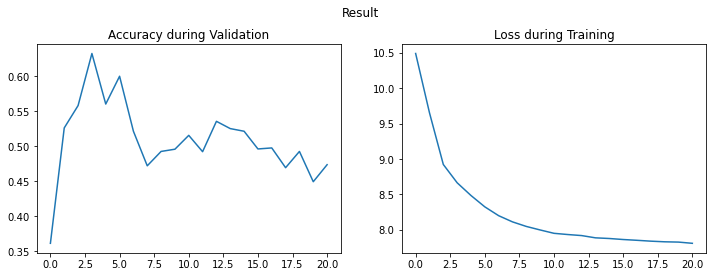

In [15]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].plot(accs)
ax[0].set_title('Accuracy during Validation')
ax[1].plot(losses)
ax[1].set_title('Loss during Training')

plt.subplots_adjust(top=0.85)
plt.suptitle('Result')
plt.show()

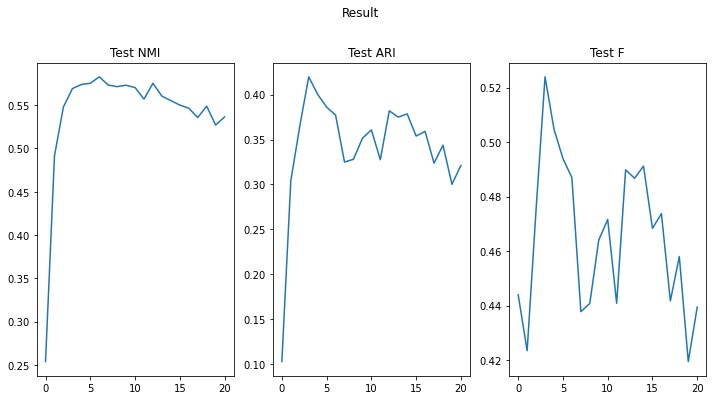

In [16]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
ax[0].plot(nmis)
ax[0].set_title('Test NMI')
ax[1].plot(aris)
ax[1].set_title('Test ARI')
ax[2].plot(fs)
ax[2].set_title('Test F')


plt.subplots_adjust(top=0.85)
plt.suptitle('Result')
plt.show()